# Finding line lanes on the road


Explanations of how to find use computer vision to detect line lanes. In this notebook I explain in more detail the project 1 of self driving car nanodegree.

In [1]:
#import libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from functools import partial
%matplotlib inline

#hiperparameters
gaussian_kernel_size=9
canny_low_threshold, canny_high_threshold = (100,255)
LOW_BORDER_Y=0
HIGH_BORDER_Y= 350
LOW_BORDER_X = 0
HIGH_BORDER_X = 200

#presentation parameters
font = cv2.FONT_HERSHEY_SIMPLEX

## Grayscale transform

An image is just a function that maps a x,y) coordinates to a vector that represents the color at the point.

f(x,y) --> value

For a color image the return value is a vector (r,g,b). A value for red, green and blue. The value of each color is normally parametrized between 0 and 255.

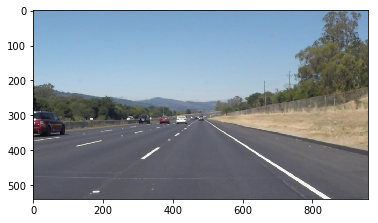

In [2]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')

plt.imshow(image)


The first pixel of image is:

In [3]:
print(image[0][0])

[180 196 209]


We don't need as much information because we don't need to distinguish between blue or red lines. We need to know just if there is a line or not. So we don't need color. To simplify we transform a color image to gray image. Instead of 3 channels (red, green, blue) we use just one.
The formula to transform a color image to a gray image is very simple:

G = (R+G+B) / 3

This is the same as doing the average between the 3 values.

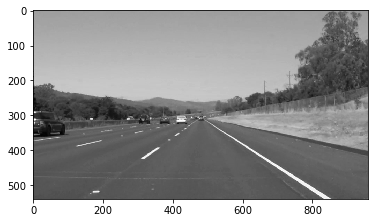

In [4]:
grey = np.zeros((image.shape[0], image.shape[1])) # init 2D numpy array
# get row number
for rownum in range(len(image)):
   for colnum in range(len(image[rownum])):
      grey[rownum][colnum] = np.average(image[rownum][colnum])
      
plt.imshow(grey, cmap='gray')

We use the opencv library to make this transformation fast.

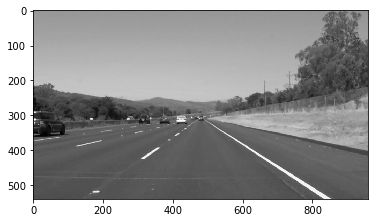

In [5]:
def gray(image):
    '''
    transforms a color image to gray
    '''
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

image_grayscale = gray(image)
plt.imshow(image_grayscale, cmap='gray')

If we compare the 2 resulting images substracting each other:

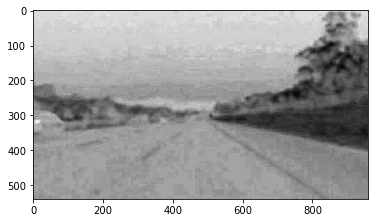

In [6]:
plt.imshow(grey - image_grayscale, cmap='gray')

If the two images were identical the resulting image would be black. It's not. That's because opencv uses a weighted average algorithm instead of doing the simple average. That's because our eyes are more sensible to some color to others and make the resulting image seem more 'natural'.


## Gaussian blur

A gaussian blur makes and image more smooth by removing small details. 

We can see the effects of the gaussian blur with different sizes of the kernel.


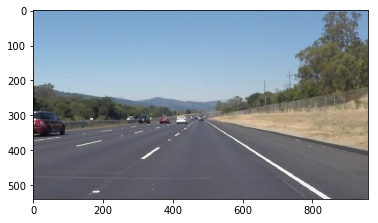

In [7]:
def gaussian_blur(image, kernel_size, sigma=0):
    '''
    image: the image to transform
    kernel_size: has to be odd
    sigma: sigma of the gaussian distribution. If 0 it's computed from the kernel size
    '''
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
    
image_blurred = gaussian_blur(image, 3)
plt.imshow(image_blurred)

Just to compare the effect of the kernel size in gaussian blur:

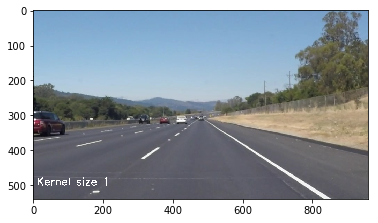

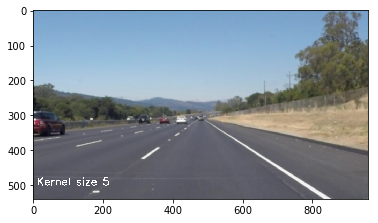

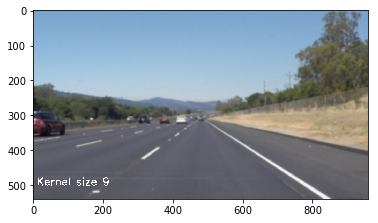

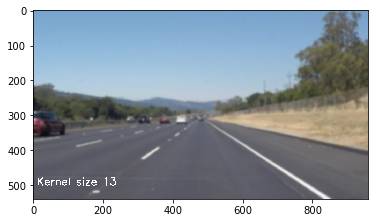

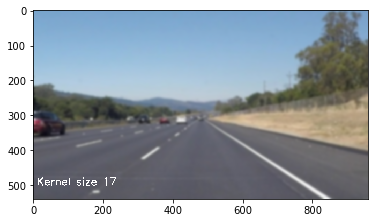

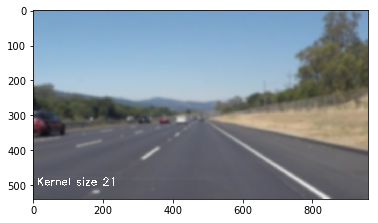

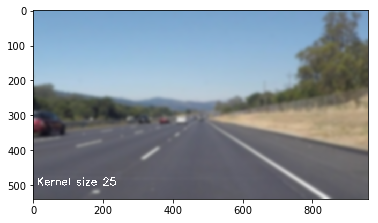

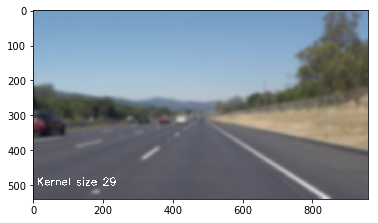

In [8]:
for i in range(1,30,4):
    plt.figure()
    img = gaussian_blur(image,i)
    cv2.putText(img,'Kernel size ' + str(i),(10,500), font, 1,(255,255,255),2)
    plt.imshow(img)

So the kernel size is an hyperparameter that we can adjust to remove detail in the image.

The gaussian blur is applied to the gray image so the result is:


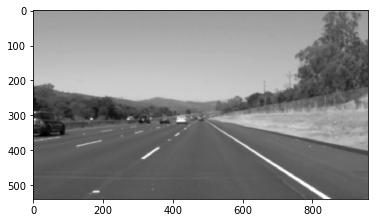

In [9]:
image_gaussian_blur = gaussian_blur(image_grayscale, gaussian_kernel_size) 
plt.imshow(image_gaussian_blur, cmap='gray')

## Canny
Another kernel transformation to 

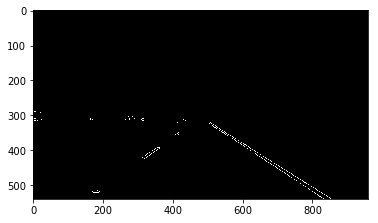

In [10]:
image_canny = cv2.Canny(image_gaussian_blur, canny_low_threshold, canny_high_threshold)
plt.imshow(image_canny, cmap='gray')

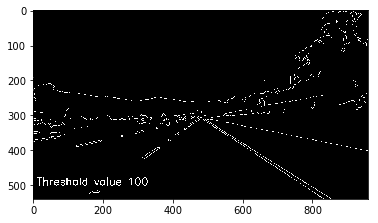

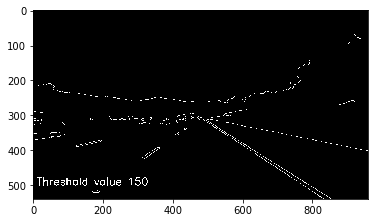

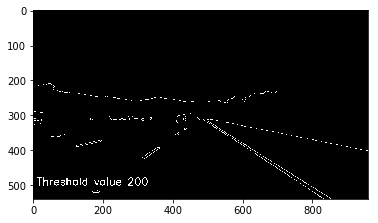

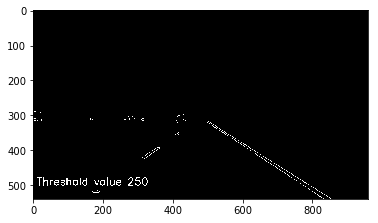

In [11]:
for threshold in range(100,255, 50):
    plt.figure()
    img = cv2.Canny(image_gaussian_blur, threshold/3, threshold)
    cv2.putText(img,'Threshold value ' + str(threshold),(10,500), font, 1,(255,255,255),2)
    plt.imshow(img, cmap='gray')

## Region of interest

We are not interested in the landscape, only in the road lane lines in front of the car. We limit our vision to just a poligon in the image.


Image shape: (540, 960, 3)


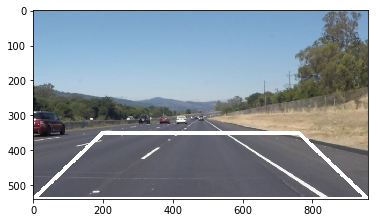

In [12]:
# Create a black image
print("Image shape:", image.shape)

def build_parallelogram(width,height, low_border_x, low_border_y, high_border_x, high_border_y):
    vertices = np.array([[low_border_x,height - low_border_y],
                         [high_border_x,high_border_y],
                         [width-high_border_x,high_border_y],
                         [width-low_border_x,height]]
    , np.int32)
    return [vertices.reshape((-1,1,2))]

image_interest = np.copy(image) #np.zeros(image.shape, np.uint8)
height,width,color = image.shape

vertices = build_parallelogram(width, height, LOW_BORDER_X, LOW_BORDER_X, HIGH_BORDER_X, HIGH_BORDER_Y)
# Draw a polygon
cv2.polylines(image_interest,vertices,True,(255,255,255),9)

#Display the image
plt.imshow(image_interest)

In [13]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

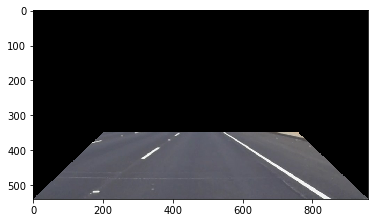

In [14]:
plt.imshow(region_of_interest(image, vertices))

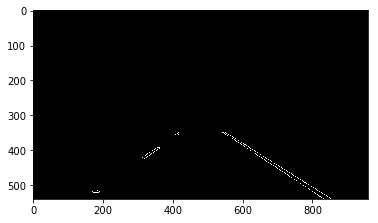

In [15]:
image_region = region_of_interest(image_canny, vertices)
plt.imshow(image_region, cmap='gray')

In [16]:
def draw_all_lines(img, lines, color=[255, 0, 0], thickness=2, min_y=0, max_y=1200):
    """
    min_y: minimum y parameter, we don't consider points that are not between min_y and max_y
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            if y1<min_y or y1>max_y:continue
            if y2<min_y or y2>max_y:continue
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, draw_lines_fn=draw_all_lines):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    if lines is None:lines=[]
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_fn(line_img, lines)
    return line_img

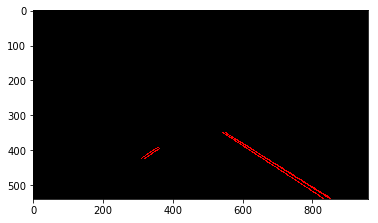

In [17]:
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 10   # minimum number of votes (intersections in Hough grid cell)
min_line_len = 40 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments

image_lines = hough_lines(image_region, rho, theta, threshold, min_line_len, max_line_gap, draw_lines_fn=draw_all_lines)
plt.imshow(image_lines)

In the picture above we have detected and marked the road line as a set of multiples small lines.

In [18]:
from sklearn.linear_model import LinearRegression


def avg_lines(lines, min_y, max_y):
    Xs = []
    Ys = []
    for x1,y1,x2,y2 in lines:
        Xs.append(y1)
        Xs.append(y2)
        Ys.append(x1)
        Ys.append(x2)
    Xs = [ (x,) for x in Xs]
    if(len(Xs)==0):return (0,0,0,0)
    model = LinearRegression()
    model.fit(Xs,Ys)
    y1=max_y
    y2=min_y
    x1=model.predict( y1 )
    x2=model.predict( y2 )
    return (x1,y1,x2,y2)

def draw_avg_lines(img, lines, min_y=0, max_y=350, color=[255, 0, 0], thickness=8):
    """
    calculate the avg slope from multiple lines. We draw 2 slopes, 
    one with positive slope and the other negative.
    In this way we distinguish between the line at our left and our right.
    """
    left_lines = []
    right_lines = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if ( (y2-y1)/(x2-x1))>0:left_lines.append( (x1,y1,x2,y2) )
            else: right_lines.append( (x1,y1,x2,y2) )
    left_line = avg_lines(left_lines, min_y, max_y)
    right_line = avg_lines(right_lines, min_y, max_y)
    for x1,y1,x2,y2 in (left_line, right_line):
        if (x1,y1,x2,y2)==(0,0,0,0):continue
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

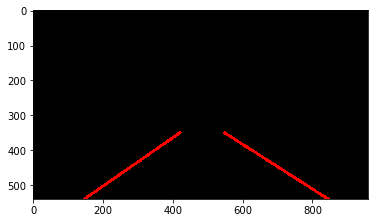

In [19]:
image_lines = hough_lines(image_region, rho, theta, threshold, min_line_len, max_line_gap, draw_lines_fn=partial(draw_avg_lines, min_y=350, max_y=image_region.shape[0]))
plt.imshow(image_lines)

In [20]:
# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def image_title(img, title=''):
    if not title:return img
    for i,line in enumerate(title.split("\n")):
        img = cv2.putText(img,line,(10,50+(i*30)), font, 1,(255,255,255),2)
    return img

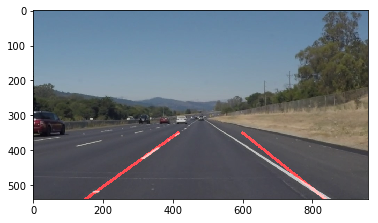

In [21]:
def image_pipeline(image, gauss_kernel_size=3,
                   canny_low_threshold=100, 
                   canny_high_threshold=255, 
                   vertices=vertices,
                   hough_rho=2,
                   hough_theta = np.pi/180,
                   hough_threshold=10,
                   hough_min_line_len=40,
                   hough_max_line_gap=20,
                   hough_min_y=350,
                   title = '',
                   draw_lines_fn=draw_avg_lines,
                   draw_vertices=False
    ):
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    img = gaussian_blur(img, gauss_kernel_size)
    img = cv2.Canny(img, canny_low_threshold, canny_high_threshold)
    img = region_of_interest(img, vertices)
    img = hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, 
                      draw_lines_fn=partial(draw_lines_fn, min_y=hough_min_y, max_y=img.shape[0]))
    img = weighted_img(img, image, α=0.8, β=1., λ=0.)
    img = image_title(img, title=title)
    if draw_vertices:cv2.polylines(img,vertices,True,(0,0,255),9)
    if len(img.shape)==2:
        return cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    return img
                       
image_final = image_pipeline(image)
plt.imshow(image_final)

def compose(*funcs):
    return lambda x: reduce(lambda v, f: f(v), reversed(funcs), x)

In [22]:
def img_show(img, msg=''):
    plt.figure()
    cv2.putText(img,msg,(10,50), font, 1,(255,255,255),2)
    plt.imshow(img)

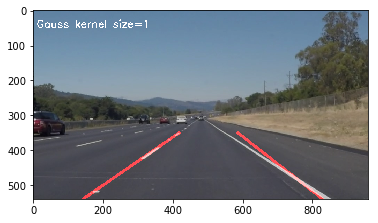

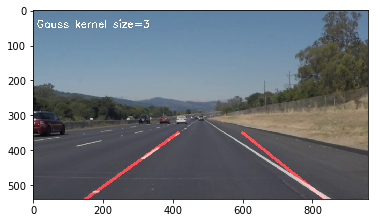

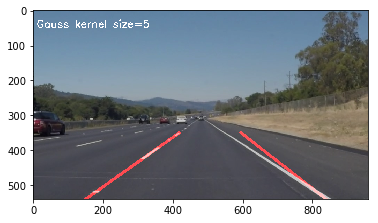

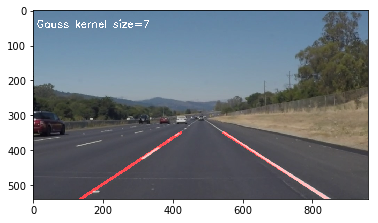

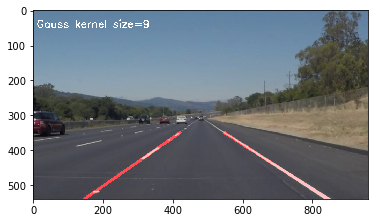

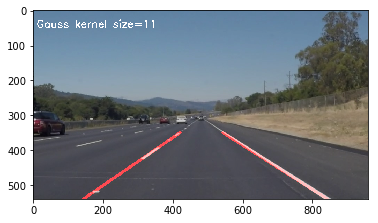

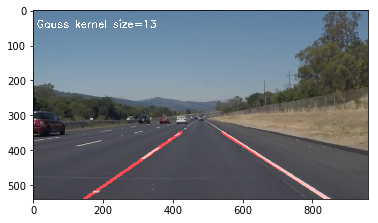

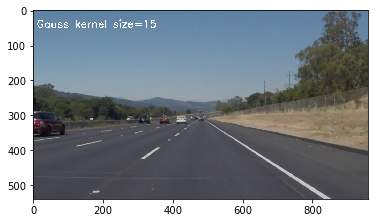

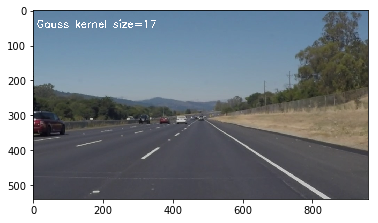

In [23]:
for i in range(1,18,2):
    img_show(image_pipeline(image, gauss_kernel_size=i),"Gauss kernel size=" + str(i))

We can see above the line detection quality depens on the gauss kernel size hyperparameter. If the value is to low the programs get confused with the small details. If the value is too high the program doesn.t detect the lines at all. We can see visually that a good value is 11.
THat value probably is not fixed, it can change with the image quality, the weather, the light, ... Maybe with a cloudy weather the program doesn't detect line lanes with gauss kernel size=11.

In [24]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_video(input, output, process_image):
    clip1 = VideoFileClip(input)
    white_clip = clip1.fl_image( process_image)
    %time white_clip.write_videofile(output, audio=False)
    return HTML("""
        <video width="960" height="540" controls>
          <source src="{0}">
        </video>
    """.format(output))

In [25]:
input = 'solidWhiteRight.mp4'
output= 'white.mp4'
process_video(input, output, image_pipeline)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:15<00:00, 11.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 44.7 s, sys: 3.09 s, total: 47.8 s
Wall time: 16.7 s


In the video above the programs detect the line lanes but makes a lot of mistakes. The programs get confused with the other lines and the border of the road.
Let's see how we can improve the detection just changing the gauss kernel size.

In [26]:
process_video(input, 'white_gauss_kernel_11.mp4', partial(image_pipeline, gauss_kernel_size=11, title='Gauss kernel size 11', draw_vertices=True))

[MoviePy] >>>> Building video white_gauss_kernel_11.mp4
[MoviePy] Writing video white_gauss_kernel_11.mp4


100%|█████████▉| 221/222 [00:15<00:00, 10.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white_gauss_kernel_11.mp4 

CPU times: user 38.7 s, sys: 2.99 s, total: 41.6 s
Wall time: 17.1 s


Just changing the gauss kernel size to 11 improves a lot the detection.

## Challenge video

Now we work with the challenge video.

In [27]:
input_challenge = 'challenge.mp4'
process_video(input_challenge, 'extra.mp4', partial(image_pipeline, gauss_kernel_size=11, title='Challenge'))

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:30<00:00,  6.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 1min 23s, sys: 6.43 s, total: 1min 30s
Wall time: 32.6 s


We can see that the program doesn't do a good job with the detection. It get's confused with the border of the road, with other lanes and with the changes in the road surface.

In [28]:
input_challenge = 'challenge.mp4'
process_video(input_challenge, 'extra2.mp4', partial(image_pipeline, title='Challenge investigation', gauss_kernel_size=11,draw_lines_fn=draw_all_lines, draw_vertices=True))

[MoviePy] >>>> Building video extra2.mp4
[MoviePy] Writing video extra2.mp4


100%|██████████| 251/251 [00:32<00:00,  6.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra2.mp4 

CPU times: user 1min 29s, sys: 6.65 s, total: 1min 35s
Wall time: 34.1 s


We can see that the first problem is that the size of the video is not the same as the other video. So we change the position of the parallelogram vertices.

In [29]:
vertices_challenge = np.array([[200,740],[490,450],[1000,450],[1200,740]], np.int32)
vertices_challenge = [vertices_challenge.reshape((-1,1,2))]

In [30]:
process_video(input_challenge, 'extra3.mp4', partial(image_pipeline, title='Challenge improvement', gauss_kernel_size=11,draw_lines_fn=draw_all_lines, vertices=vertices_challenge, draw_vertices=True))

[MoviePy] >>>> Building video extra3.mp4
[MoviePy] Writing video extra3.mp4


100%|██████████| 251/251 [00:31<00:00,  7.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra3.mp4 

CPU times: user 1min 26s, sys: 6.43 s, total: 1min 32s
Wall time: 33.9 s


In the previous video we show all the hough lines, not the averages. We detect the lines but there is some problems with other edges that fit inside the parallelogram, like the bottom of the car, other lines, road border and pavement.

In [31]:
def avg_lines(lines, min_y, max_y):
    Xs = []
    Ys = []
    for x1,y1,x2,y2 in lines:
        Xs.append(y1)
        Xs.append(y2)
        Ys.append(x1)
        Ys.append(x2)
    Xs = [ (x,) for x in Xs]
    if(len(Xs)==0):return (0,0,0,0)
    model = LinearRegression()
    model.fit(Xs,Ys)
    y1=max_y
    y2=min_y
    x1=model.predict( y1 )
    x2=model.predict( y2 )
    return (x1,y1,x2,y2)

def draw_improved_lines(img, lines, min_y=0, max_y=350, color=[255, 0, 0], thickness=8, min_slope=0.4):
    """
    In this version of draw lines we remove all the lines with an abs value of the slope lower than min_slope.
    That helps to remove horizontal lines like the bottom of the car and the pavement.
    """
    left_lines = []
    right_lines = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2-y1)/(x2-x1)
            if abs(m)< min_slope:continue
            if m>0:left_lines.append( (x1,y1,x2,y2) )
            else: right_lines.append( (x1,y1,x2,y2) )
    left_line = avg_lines(left_lines, min_y, max_y)
    right_line = avg_lines(right_lines, min_y, max_y)
    for x1,y1,x2,y2 in (left_line, right_line):
        if (x1,y1,x2,y2)==(0,0,0,0):continue
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

In [32]:
process_video(input_challenge, 'extra3.mp4', partial(image_pipeline, title='Challenge improvement', gauss_kernel_size=11,draw_lines_fn=draw_improved_lines,vertices=vertices_challenge, hough_min_y=450, draw_vertices=True))

[MoviePy] >>>> Building video extra3.mp4
[MoviePy] Writing video extra3.mp4


100%|██████████| 251/251 [00:33<00:00,  6.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra3.mp4 

CPU times: user 1min 22s, sys: 6.5 s, total: 1min 28s
Wall time: 36 s


The line detection has improved a lot but it still has mistakes. It still gets confused with the change of pavement. We can improve that. The lane lines are painted in white or yellow and the line has a minimum thickness. The program gets confused with the second lane lines. We have to distinguish between the lane lines that we are inside and the other.